# For Personal Use

- Are there any cases where we use *softmax* before the output or do we always employ MSE Loss when solving ODEs?
- How would solving one of the first-order ODE using Neural ODE paradigm would be different than solving it using a Feed-forward Neural Network?
- What are some physical scenarios that might require 2 physics losses? Perhaps the case of modeling the motion of a charged particle in an electromagnetic field. We would have two losses then: One loss enforcing Maxwell’s equations for the electromagnetic field and another loss enforcing Newton’s laws for the particle's motion.


# Resources & Links:

- For [Unsupervised Eigenfunction Problem](https://github.com/henry1jin/eigeNN/blob/master/BothBounds_Harmonic.ipynb)
- QHO solved using Unsupervised Eigenfunction [Formulation](https://github.com/AnishD11/PINN-Quantum-Harmonic-Oscillator/blob/main/PINN1D.ipynb)
- Further read on solving QHO using unsupervised method [Read](https://github.com/karanprime/TDSE_PINN_Kiel/blob/main/TD_Schrodinger.ipynb)
- Repository of [PINNs](https://github.com/mushrafi88/Physics-Informed-Neural-Networks-for-Quantum-Dynamics/blob/main/Quantum_DE_PINN.ipynb)


# General Comments & Ideas to understand the code

- ReLU destablizes training for some reasons in context of Classical Harmonic Oscillator Problem. Generally, ReLU is not the go to choice activation for PINNs.
- The paper Hamiltonian Neural Networks for Solving
Differential Equations introduces sin(.) activations which are used in my implementation also. The authors of the paper state: **We choose the trigonometric sin(·) as the activation function and show that the NN converges to the solutions with less training iterations than using the sigmoid activation**. Read the paper in future.
- For `x_data points`, a batch of $x_i$ points in the interval $[x_L, x_R]$ are selected as input where L indicates the left side of the boundary and R indicates the right side. In every training iteration (epoch) the input points are perturbed by a Gaussian noise to prevent the network from learning the solutions only at fixed points [See the paper](https://arxiv.org/pdf/2203.00451)). These improves the models performance and prevents overfitting. We will use the function `PerturbPoints` to carry this out.
- Read the paper, **"Unsupervised neural networks for quantum eigenvalue problems"**

# Preliminaries

###  Imports

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim

import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm  # For progress bar

from scipy.special import hermite
from scipy.special import factorial

import time
import copy

from mpl_toolkits.mplot3d import Axes3D
from torch.autograd import Variable


### Neural Network

We will define a general neural network that maps a vector from $\mathbb{R}^N$ to $\mathbb{R}^M$. That is:

  $$f: \mathbb{R}^N →  \mathbb{R}^M$$

In [ ]:
class CustomNN(nn.Module):
    def __init__(self, input_dim, output_dim, hidden_dim, num_layers):
        super(CustomNN, self).__init__()
        layers = []
        ################## activation functions (try varying these) ##########
        activation_fn = torch.sin  # Use torch.sin for sine activation

        ##################################################################

        # Input to the first hidden layer
        layers.append(nn.Linear(input_dim, hidden_dim))

        # Hidden layers
        for _ in range(num_layers):
            layers.append(nn.Linear(hidden_dim, hidden_dim))

        # Output layer
        layers.append(nn.Linear(hidden_dim, output_dim))

        self.layers = nn.ModuleList(layers)

    def forward(self, x):
        for i, layer in enumerate(self.layers[:-1]):
            x = layer(x)
            x = torch.sin(x)  # Apply sine activation

        x = self.layers[-1](x)  # No activation on the output layer
        return x



# Example usage:
input_dim = 2  # R^2 as input
output_dim = 1  # R^1 as output
model = CustomNN(input_dim, output_dim, 32,3)

# Example input (batch size of 5, input_dim of 2)
X_train = torch.randn(5, input_dim)

# Forward pass
out = model(X_train)
print(out.shape)  # Expected output: torch.Size([5, 1])

class FCN(nn.Module):
    "Defines a connected network"
    def __init__(self, N_INPUT, N_OUTPUT, N_HIDDEN, N_LAYERS):
        super().__init__()
        activation = nn.Tanh
        self.fcs = nn.Sequential(*[
                        nn.Linear(N_INPUT, N_HIDDEN),
                        activation()])
        self.fch = nn.Sequential(*[
                        nn.Sequential(*[
                            nn.Linear(N_HIDDEN, N_HIDDEN),
                            activation()]) for _ in range(N_LAYERS-1)])
        self.fce = nn.Linear(N_HIDDEN, N_OUTPUT)

    def forward(self, x):
        x = self.fcs(x)
        x = self.fch(x)
        x = self.fce(x)
        return x

torch.Size([5, 1])


### MSE loss

In [ ]:
def mse_loss(y_pred, y_true):

    loss = torch.mean((y_pred - y_true) ** 2)
    return loss

### Perturb Points

The function perturbs the input points by adding noise proportional to the spacing between the points, ensuring that the boundaries remain fixed. Mathematically, for each input. Let the x_data points be $x = \{x_0, x_1, x_2, \dots, x_n\}$ where $ x_0 $ and $ x_n $ are boundary points. For each interior point $ x_i $ where $ 1 \leq i \leq n-1 $, the perturbation is defined as $ \delta_x = x_1 - x_0 $

This captures the spacing between points, and the noise added to each point is $ \text{noise}(x_i) = \delta_x \cdot \mathcal{N}(0, \sigma) $ where $ \mathcal{N}(0, \sigma) $ is a Gaussian noise with mean 0 and standard deviation $ \sigma $.Therefore, the perturbed point becomes $
\tilde{x}_i = x_i + \delta_x \cdot \mathcal{N}(0, \sigma)
$

The perturbed points are clamped to the range $ [x_0, x_n] $ to ensure that the perturbations do not go beyond the fixed boundaries: $ \tilde{x}_i = \text{clamp}(\tilde{x}_i, x_0, x_n)
$


In [ ]:
# from: https://github.com/AnishD11/PINN-Quantum-Harmonic-Oscillator/blob/main/PINN1D.ipynb

def PerturbPoints(x_points: torch.Tensor, sig=0.5) -> torch.Tensor:
    """Adds noise to x-points proportional to the spacing between them keeping the boudaries fixed"""
    x_0 = x_points[0]
    x_f = x_points[-1]
    delta_x = x_points[1] - x_points[0]
    noise = delta_x * torch.randn_like(x_points) * sig
    #noise = torch.normal(mean=mu, std=sig, size=x_points.shape)
    perturbed_x_points = x_points + noise
    perturbed_x_points[0] = x_0
    perturbed_x_points[-1] = x_f
    perturbed_x_points = torch.clamp(perturbed_x_points, min=x_0, max=x_f)
    perturbed_x_points.requires_grad = False
    return perturbed_x_points

### Plot Util

In [ ]:
def plot_result(x,y,x_data,y_data,yh,xlim_low,xlim_high,ylim_low,ylim_high,xp=None):
    "Pretty plot training results"
    plt.figure(figsize=(8,4))
    plt.plot(x,y, color="grey", linewidth=2, alpha=0.8, label="Exact solution")
    plt.plot(x,yh, color="tab:blue", linewidth=3, alpha=0.8, label="Neural network prediction")
    plt.scatter(x_data, y_data, s=60, color="tab:orange", alpha=0.4, label='Training data')
    if xp is not None:
        plt.scatter(xp, -0*torch.ones_like(xp), s=60, color="tab:green", alpha=0.4,
                    label='Physics loss training locations')
    l = plt.legend(loc=(1.01,0.34), frameon=False, fontsize="large")
    plt.setp(l.get_texts(), color="k")
    plt.xlim(xlim_low, xlim_high)
    plt.ylim(ylim_low, ylim_high)
    plt.text(1.065,0.7,"Training step: %i"%(i+1),fontsize="xx-large",color="k")
    plt.axis("off")

# Classical Harmonic Oscillator


### TO DO

1. Solve the n-dimensional harmonic oscillator problem
2. Solve the harmonic oscillator with $\omega$ being learnable.
3. Make the Neural Network pipeline wiht [layers, activation_function] modified.

### 1D classical Harmonic Oscillator

Let me begin by coding the classical **harmonic oscillator**. We will begin by coding the 1D harmonic oscillator and then we will generalize to the N-dimensional case.  The Equation of Motion that governs the 1D harmonic oscillator is:
$$
\frac{d^2x(t)}{dt^2} + \omega^2 x(t) = 0
$$

where $ x(t) \in \mathbb{R}^1$ is the displacement of the particle and $ \omega $ is the angular frequency. Therefore, our neural network f would be a map:

$$ f(x''(t),x(t),t):\mathbb{R}^1 → \mathbb{R}^1  $$

Recall that the angular frequency  $\omega$  is given by $\omega = \sqrt{\frac{k}{m}}$, where $ k $ is the spring constant and $ m $ is the mass of the particle. The period of oscillation is $ T = \frac{2\pi}{\omega} $, which describes how long it takes for one complete cycle.


### Plotting the Analytical Solution

The general solution to the above equation is $
x(t) = A \cos(\omega t) + B \sin(\omega t)$ where $ A $ and $ B $ are constants determined by the initial conditions (initial displacement and velocity). This can usually be writen as $x(t) = A \cos(\omega t + \phi)$ where $\phi$ is the phase factor. The constants A, $\omega$, $\phi$ will be hard-coded.



In [ ]:
# Define constants
A = 1       # Amplitude
omega = 20     # Angular frequency (rad/s)
phi = 0     # Initial phase (can be adjusted based on initial conditions)

def harmonic_oscillator(A, w0, phi, x):
    cos = torch.cos(w0 * x + phi)
    y = A * cos
    return y


x = torch.linspace(0, 1, 500).view(-1, 1)  # Time range from 0 to 1, with 500 points
y = harmonic_oscillator(A, omega, phi, x).view(-1, 1)
print("total number of points in the entire space", x.shape, y.shape)

# Slice out a small number of points from the left-hand side (LHS) of the domain
x_data = x[0:200:20]  # only 10 elements
x_perturbed = PerturbPoints(x_data)
y_data = harmonic_oscillator(A, omega, phi, x_perturbed).view(-1, 1)
print("total number of points selected for training", x_perturbed.shape, y_data.shape)


total number of points in the entire space torch.Size([500, 1]) torch.Size([500, 1])
total number of points selected for training torch.Size([10, 1]) torch.Size([10, 1])


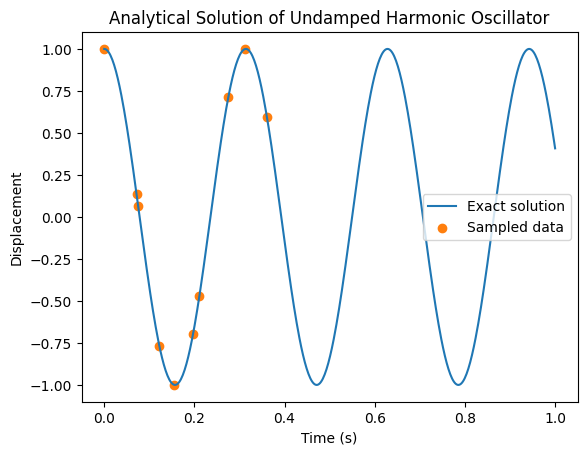

In [ ]:
# Plot the exact solution and sampled data points
plt.figure()
plt.plot(x, y, label="Exact solution")
plt.scatter(x_perturbed, y_data, color="tab:orange", label="Sampled data")
plt.legend()
plt.title("Analytical Solution of Undamped Harmonic Oscillator")
plt.xlabel("Time (s)")
plt.ylabel("Displacement")
plt.show()


### Physics Loss

In [ ]:
def physics_loss(model, t_physics, omega):
    """
    Equation: x'' + a^2 x = 0
    Parameter1: x_physics -> The output from our neural network aka x(t)
    Parameter2: omega -> The angular frequency

    """

    xhp = model(t_physics) # x(t)

    # Compute the first derivative: dx/dt
    dx = torch.autograd.grad(xhp, t_physics, torch.ones_like(xhp), create_graph=True)[0]
    # torch.one_like is necesarily because the input w.r.t which we are differentiating
    #is a tensor itself

    # Compute the second derivative: d^2x/dt^2
    dx2 = torch.autograd.grad(dx, t_physics, torch.ones_like(dx), create_graph=True)[0]

    # Compute the residual of the equation: x'' + a^2 * x = 0
    physics_residual = dx2 + omega**2 * xhp

    # Compute the physics loss as the mean squared value of the residual
    loss = torch.mean(physics_residual ** 2)


    return loss

### Defining Physics Domain

We had defined `x_data`. These are points where we had an observational or experimental data. We will now define `x_physics` which are the points over the domain where we want enforce the governing differential equation. Note that  **data loss** and **physics loss** are computed at different points in the domain. Furthermore, in traditional settings, you don't evaluate at test_regions. For example, if our train-test split is [0.4,0.6], we will not perform any sort of loss-computation on t > 0.4 since that data is explicitly held out for testing. However, the physics loss above is applied **across the entire domain**, regardless of whether we have training data or not.


In [ ]:
x_physics = torch.linspace(0, 1, 30).view(-1, 1).requires_grad_(True)
#print(x_physics) # unprint to see how its defined over the netire domain

### Training

Training Progress:  13%|█▎        | 3026/24000 [00:17<02:41, 130.00it/s]

Epoch 3000, Data Loss: 0.5172125697135925, Physics Loss: 0.00021895495592616498, Total Loss: 0.5174314975738525


Training Progress:  25%|██▍       | 5982/24000 [00:35<01:30, 198.04it/s]

Epoch 6000, Data Loss: 0.07860509306192398, Physics Loss: 0.09552080184221268, Total Loss: 0.17412589490413666


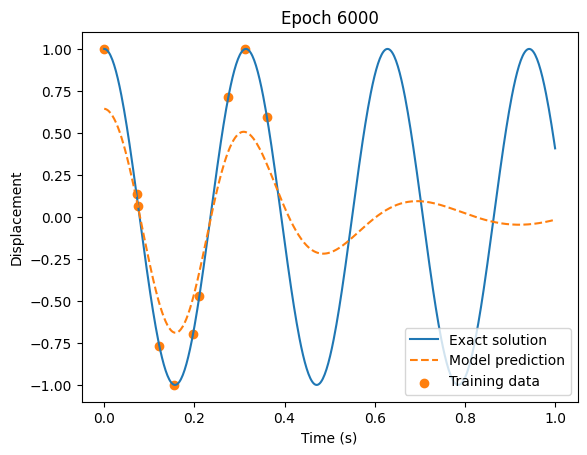

Training Progress:  38%|███▊      | 9026/24000 [00:53<01:22, 181.59it/s]

Epoch 9000, Data Loss: 2.6135336156585254e-05, Physics Loss: 0.0006530160899274051, Total Loss: 0.0006791514460928738


Training Progress:  50%|████▉     | 11994/24000 [01:11<01:39, 120.47it/s]

Epoch 12000, Data Loss: 1.4350746369018452e-06, Physics Loss: 9.740270616021007e-05, Total Loss: 9.883777966024354e-05


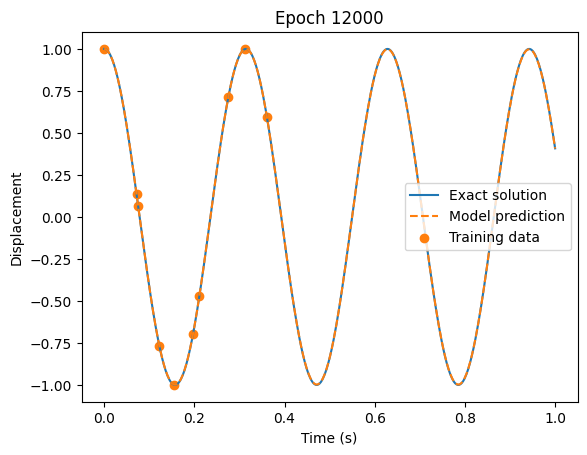

Training Progress:  63%|██████▎   | 15008/24000 [01:35<03:04, 48.61it/s]

Epoch 15000, Data Loss: 2.139368717735124e-07, Physics Loss: 6.42750455881469e-05, Total Loss: 6.448898056987673e-05


Training Progress:  75%|███████▍  | 17982/24000 [02:01<00:30, 197.30it/s]

Epoch 18000, Data Loss: 4.903287020852076e-08, Physics Loss: 4.141936733503826e-05, Total Loss: 4.146840001340024e-05


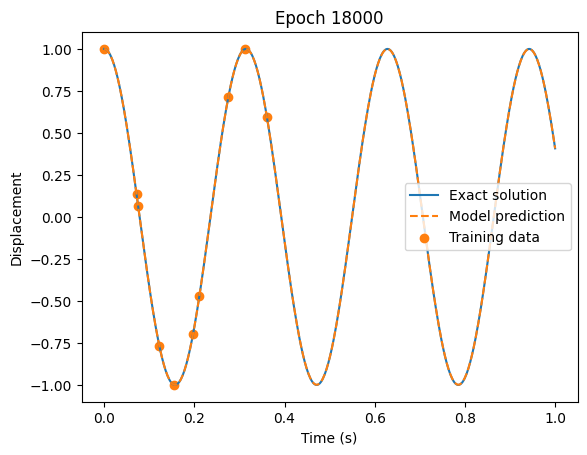

Training Progress:  88%|████████▊ | 21037/24000 [02:22<00:16, 181.62it/s]

Epoch 21000, Data Loss: 3.382503166449169e-08, Physics Loss: 3.415641185711138e-05, Total Loss: 3.419023778405972e-05


Training Progress: 100%|█████████▉| 23981/24000 [02:39<00:00, 193.07it/s]

Epoch 24000, Data Loss: 2.8853639477688375e-08, Physics Loss: 2.895426041504834e-05, Total Loss: 2.8983113224967383e-05


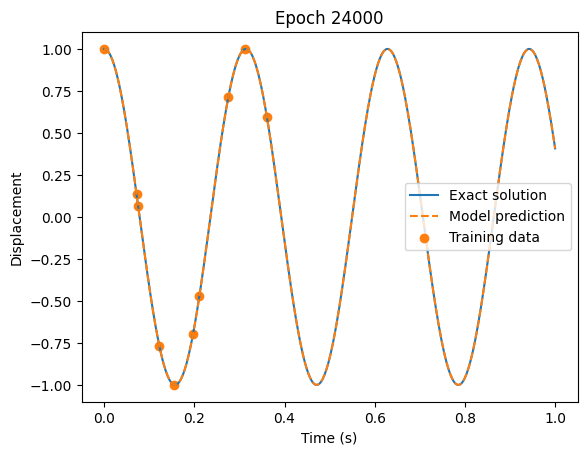

Training Progress: 100%|██████████| 24000/24000 [02:39<00:00, 150.29it/s]


In [ ]:


# Initialize the model
model = CustomNN(1,1,32,3)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)

# For plotting results
data_loss_history = []
physics_loss_history = []
total_loss_history = []

# Training loop with tqdm
epochs = 24000
for epoch in tqdm(range(epochs), desc="Training Progress"):
    optimizer.zero_grad()

    # Compute the data loss
    y_pred = model(x_perturbed)
    data_loss = mse_loss(y_pred, y_data)

    # Compute the physics loss
    physics_loss_val = physics_loss(model, x_physics, omega)
    scaled_value = (1e-4)
    physics_loss_val = physics_loss_val * scaled_value

    # Total loss (data loss + physics loss with scaling factor for physics loss)
    total_loss = data_loss + physics_loss_val

    # Backpropagation
    total_loss.backward()
    optimizer.step()

    # Store loss values for plotting
    data_loss_history.append(data_loss.item())
    physics_loss_history.append(physics_loss_val.item())
    total_loss_history.append(total_loss.item())

    # Plot every 3000 epochs
    if (epoch + 1) % 3000 == 0:
        print(f"Epoch {epoch + 1}, Data Loss: {data_loss.item()}, Physics Loss: {physics_loss_val.item()}, Total Loss: {total_loss.item()}")
    if (epoch + 1) % 6000 == 0:
        with torch.no_grad():
            y_pred_full = model(x).detach()
            plt.plot(x, y, label="Exact solution")
            plt.plot(x, y_pred_full, label="Model prediction", linestyle="--")
            plt.scatter(x_perturbed, y_data, color="tab:orange", label="Training data")
            plt.legend()
            plt.title(f"Epoch {epoch + 1}")
            plt.xlabel("Time (s)")
            plt.ylabel("Displacement")
            plt.show()


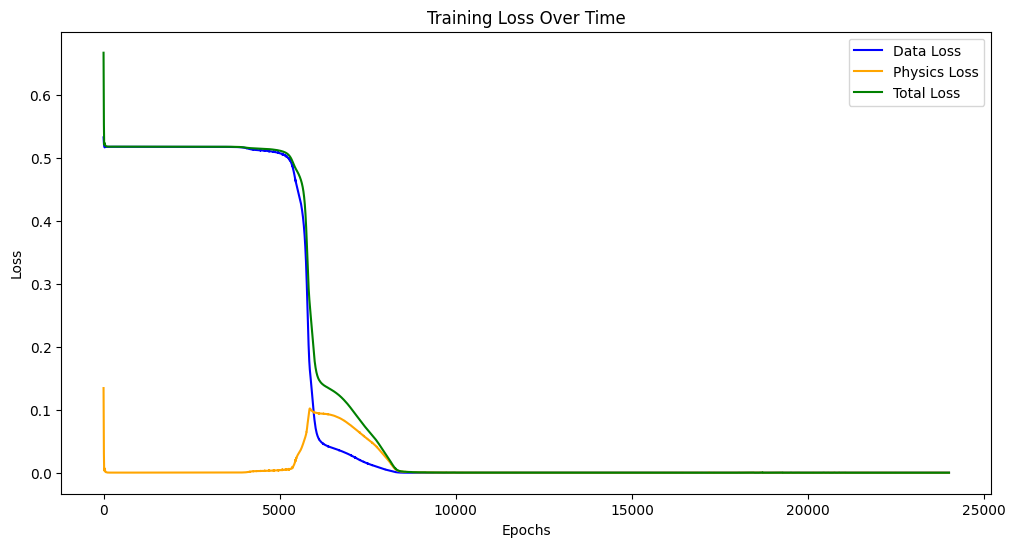

In [ ]:
# Plot the loss histories for data loss, physics loss, and total loss
def plot_losses(data_loss_history, physics_loss_history, total_loss_history):
    plt.figure(figsize=(12, 6))

    # Plot data loss
    plt.plot(data_loss_history, label='Data Loss', color='blue')

    # Plot physics loss
    plt.plot(physics_loss_history, label='Physics Loss', color='orange')

    # Plot total loss
    plt.plot(total_loss_history, label='Total Loss', color='green')

    # Set the labels and title
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.title('Training Loss Over Time')

    # Show legend
    plt.legend()

    # Display the plot
    plt.show()

# Call the function to plot the losses
plot_losses(data_loss_history, physics_loss_history, total_loss_history)




# Quantum Harmonic Oscillator

### Problem Overview

The Hamiltonian for the quantum harmonic oscillator is:

$$
\hat{H} = \frac{\hat{p}^2}{2m} + \frac{1}{2} m \omega^2 \hat{x}^2
$$

The differential equation is given by:

$$
[-\frac{\hbar^2}{2m} \frac{d^2}{dx^2} + \frac{1}{2} m \omega^2 x^2] \psi(x) = E \psi(x)
$$

where $\psi(x) → 0 $ as $x → ∞, - ∞$

With the prescribed solution, this turns into:

$$
[\frac{d^2}{dx^2} - \frac{m^2 \omega^2 x^2}{\hbar^2}  + \frac{2 m \omega}{\hbar} \left( n + \frac{1}{2} \right) ] \psi_n(x) = 0
$$



### The eigenfunctions of Quantum Harmonic Oscillator

For the equation above, the corresponding eigenfunction, which are the solutions to the Schrödinger equation are:

$$
\psi_n(x) = \left( \frac{m \omega}{\pi \hbar} \right)^{1/4} \frac{1}{\sqrt{2^n n!}} H_n \left( \sqrt{\frac{m \omega}{\hbar}} x \right) e^{-\frac{m \omega x^2}{2 \hbar}}
$$

Here, $H_n$ are the Hermite polynomials of degree $n$, which are orthogonal polynomials that arise in the solution of the Schrödinger equation for the harmonic oscillator. In order to define these in python, we can use `scipy` library.

For the code, we set the constants m= $\omega$=$\hbar$ =1


In [ ]:


def quantum_harmonic_oscillator(n, x):
    """
    Quantum harmonic oscillator state function for n-th energy level.

    Parameters:
    - n: Quantum number
    - x: Position (torch.Tensor)

    Returns:
    - y: The n-th state wave function evaluated at x
    """
    # Given values
    m = 1  # mass
    omega = 1  # angular frequency
    hbar = 1  # reduced Planck's constant
    prefactor = ((m*omega)/(np.pi*hbar))**0.25
    normalization = 1 / np.sqrt(2**n * factorial(n)) # from scipy.factorial
    x_np = x.numpy()
    # Calculate the Hermite polynomial H_n
    H_n = hermite(n)(np.sqrt(m*omega/hbar)*x_np)
    # Compute the wave function
    y_np = prefactor * normalization * H_n * np.exp(-m*omega*x_np**2 / (2*hbar))
    # Convert the result back to a torch.Tensor
    y = torch.from_numpy(y_np).type_as(x)
    return y

#  the analytical solution over the full domain
n = 13 # nth eigenstate
x = torch.linspace(-12,12,10000).view(-1,1) # we define domain from [-12, 12]
y = quantum_harmonic_oscillator(n, x).view(-1,1)
print(x.shape, y.shape)



torch.Size([10000, 1]) torch.Size([10000, 1])


torch.Size([40, 1]) torch.Size([40, 1])


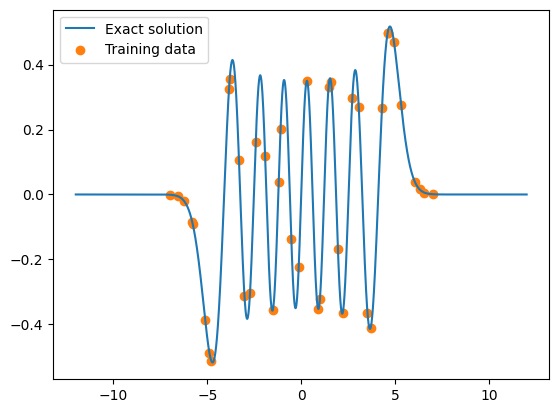

In [ ]:
# Generate 20 equally spaced data points within the range [-7, 7]
x_start, x_end = -7, 7
num_points = 40
x_data = torch.linspace(x_start, x_end, num_points).view(-1, 1)
x_perturbed = PerturbPoints(x_data)
y_data = quantum_harmonic_oscillator(n, x_perturbed).view(-1, 1)
print(x_perturbed.shape, y_data.shape)

plt.figure()
plt.plot(x, y, label="Exact solution")
plt.scatter(x_perturbed, y_data, color="tab:orange", label="Training data")
plt.legend()
plt.show()

### Physics Loss

In [ ]:
def physics_loss(model, x_physics, n):
    """
    Equation: y'' - g(x) y + b y  = 0
    g(x) = x^2
    b = 2*(n + 0.5)
    """

    yhp = model(x_physics)  # y(x)
    dy  = torch.autograd.grad(yhp, x_physics, torch.ones_like(yhp), create_graph=True)[0]  # computes dy/dx
    dy2 = torch.autograd.grad(dy, x_physics, torch.ones_like(dy), create_graph=True)[0]   # computes d^2y/dx^2

    physics_residual = dy2 - (x_physics ** 2) * yhp + 2 * (n + 0.5) * yhp

    loss = torch.mean(physics_residual ** 2)

    return loss



### Training

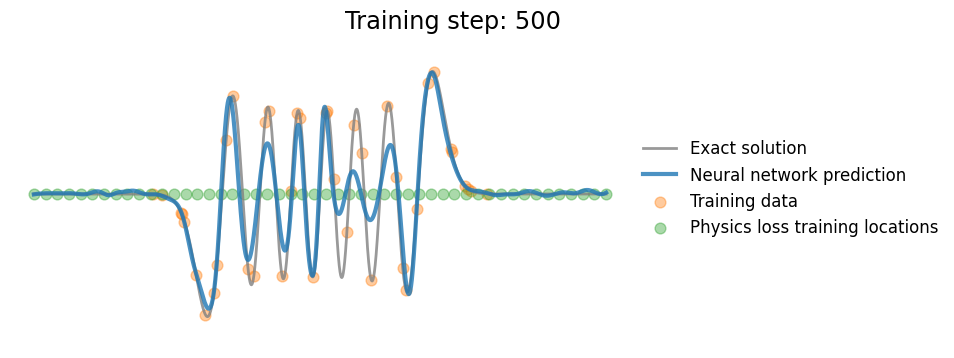

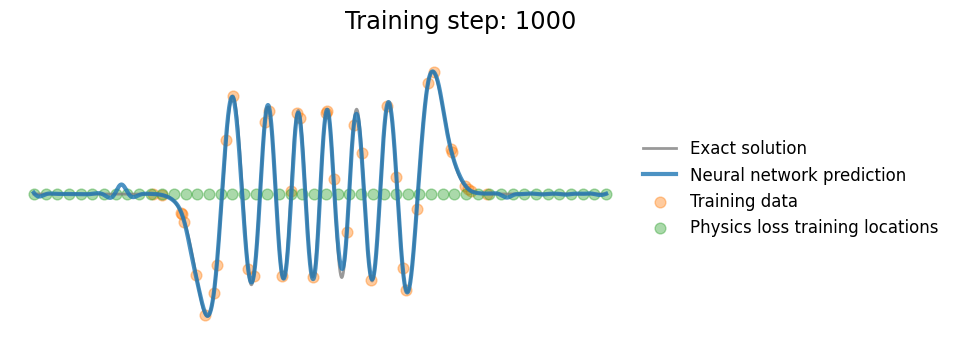

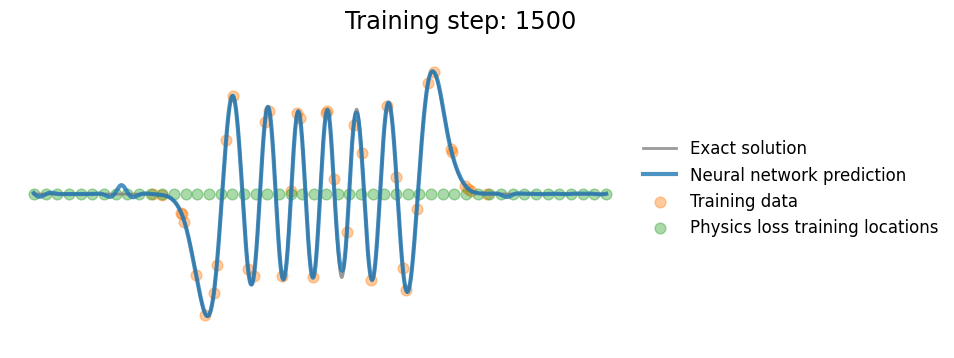

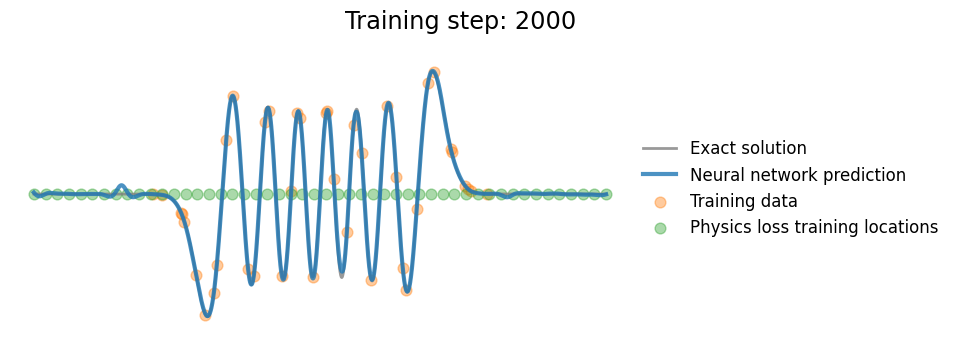

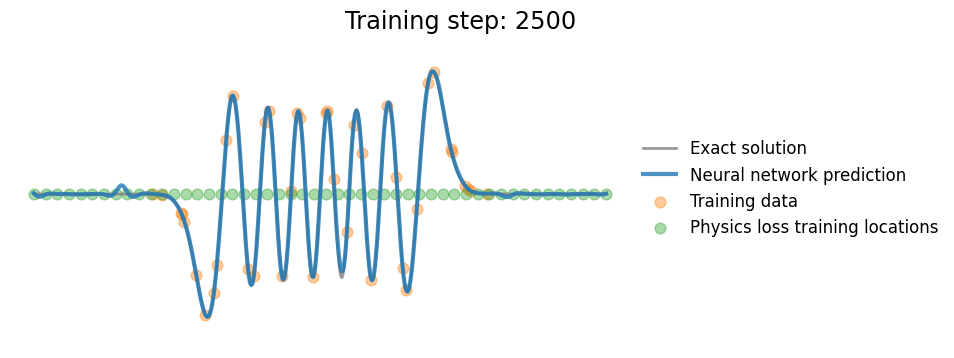

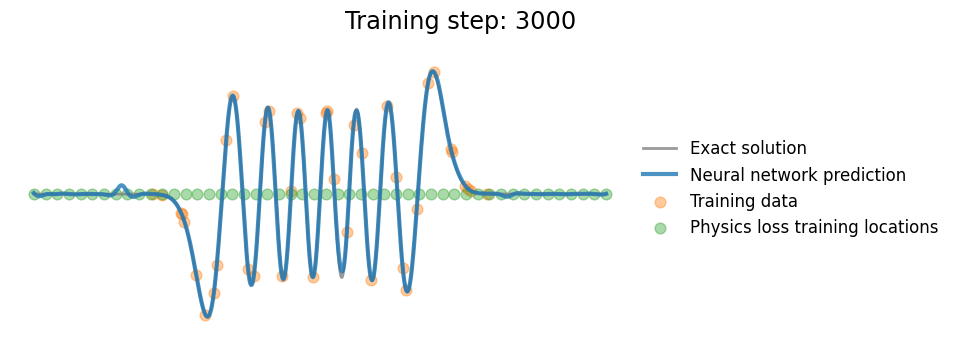

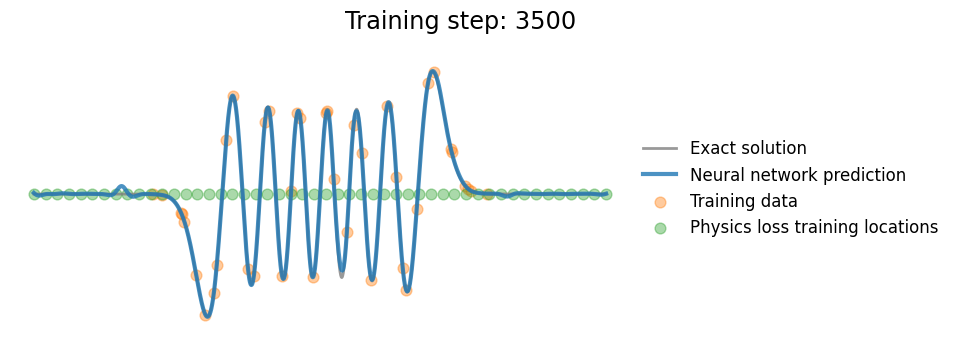

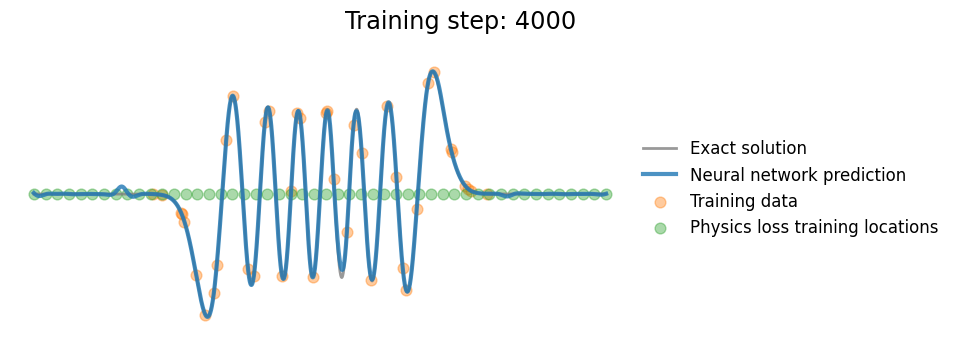

KeyboardInterrupt: 

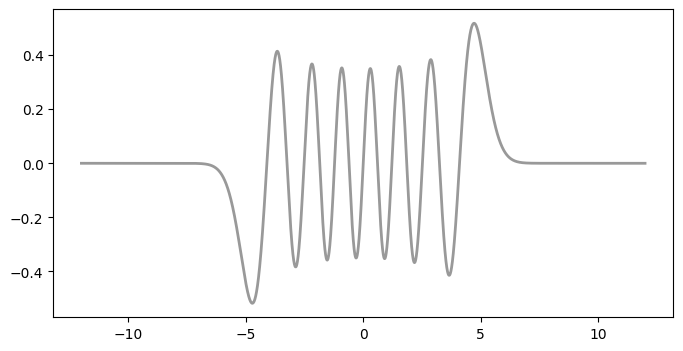

In [ ]:

x_physics = torch.linspace(-12,12,50).view(-1,1).requires_grad_(True) # sample locations over the problem domain

torch.manual_seed(123)
model = CustomNN(1,1,32,3)
#device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

optimizer = torch.optim.Adam(model.parameters(),lr=5e-3)

data_loss_history = []
physics_loss_history = []
total_loss_history = []

#plt.close()
for i in range(6000):
    optimizer.zero_grad()

    # compute the "data loss"
    yh = model(x_perturbed)
    loss1 = mse_loss(yh,y_data)
    data_loss_history.append(loss1.item())

    # compute the "physics loss"
    loss2 = physics_loss(model, x_physics, n)
    scaled = 5e-3
    loss2 = loss2 * scaled
    physics_loss_history.append(loss2.item())

    # backpropagate joint loss
    loss = loss1 + loss2# add two loss terms together
    total_loss_history.append(loss.item())
    loss.backward()
    optimizer.step()

    # plot the result as training progresses
    if (i+1) % 5 == 0:
        yh = model(x).detach()
        xp = x_physics.detach()
        xlim_low = -13
        xlim_high = 13
        ylim_low = -0.65
        ylim_high = 0.65
        plot_result(x,y,x_perturbed,y_data,yh,xlim_low,xlim_high,ylim_low,ylim_high,xp)

        if (i+1) % 500 == 0: plt.show()
        else: plt.close("all")

### NN trained on half domain

-  This neural network only worked well when I added sine activation and perturbed my data-points. Otherwise, this methodology was not working. Do keep this in mind.  


torch.Size([40, 1]) torch.Size([40, 1])


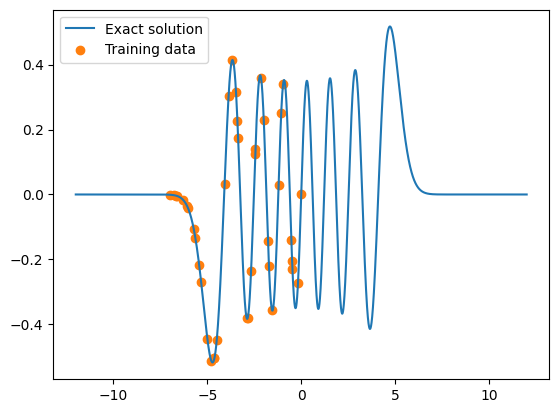

In [ ]:
# Generate 20 equally spaced data points within the range [-7, 7]
x_start, x_end = -7, 0
num_points = 40
x_data = torch.linspace(x_start, x_end, num_points).view(-1, 1)
x_perturbed = PerturbPoints(x_data)
y_data = quantum_harmonic_oscillator(n, x_perturbed).view(-1, 1)
print(x_perturbed.shape, y_data.shape)

plt.figure()
plt.plot(x, y, label="Exact solution")
plt.scatter(x_perturbed, y_data, color="tab:orange", label="Training data")
plt.legend()
plt.show()

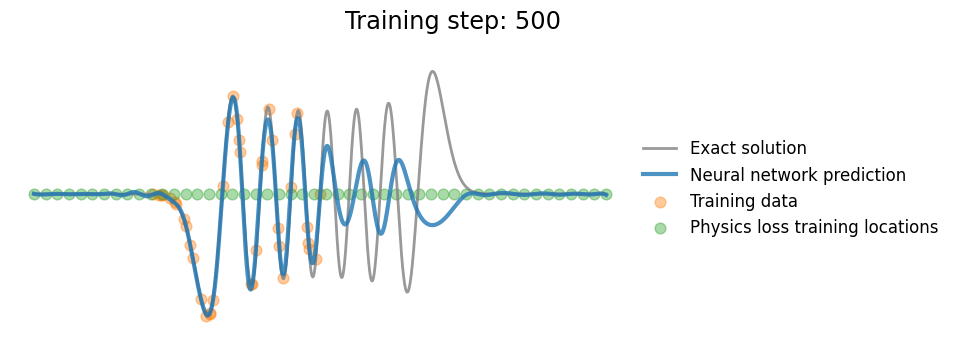

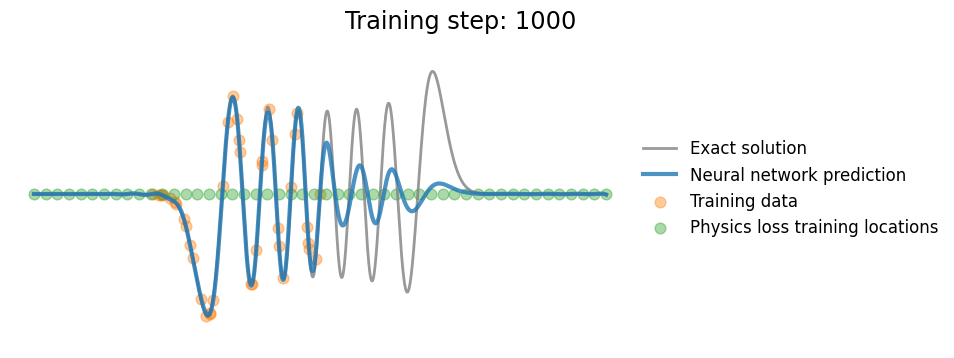

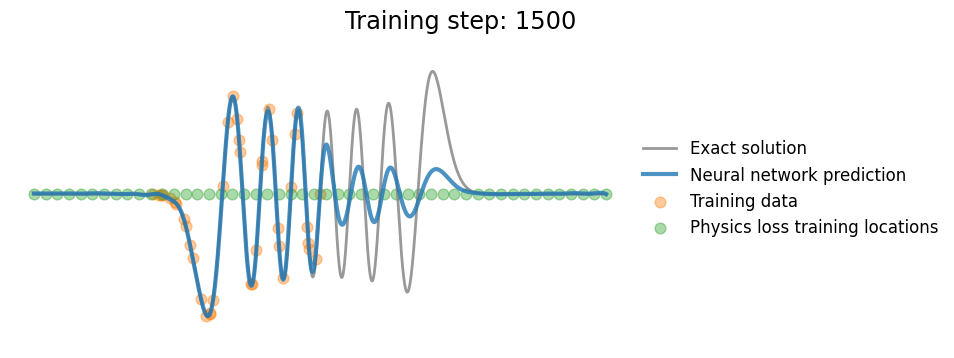

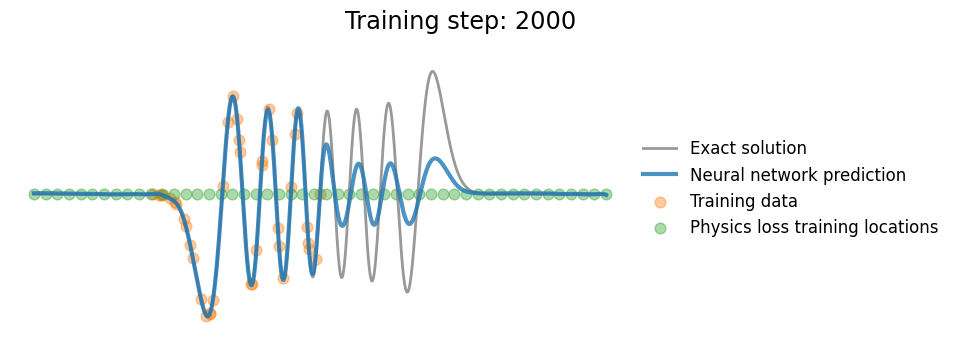

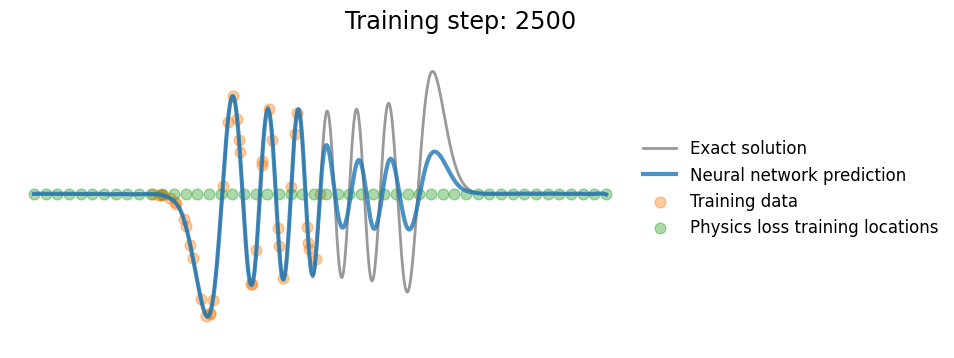

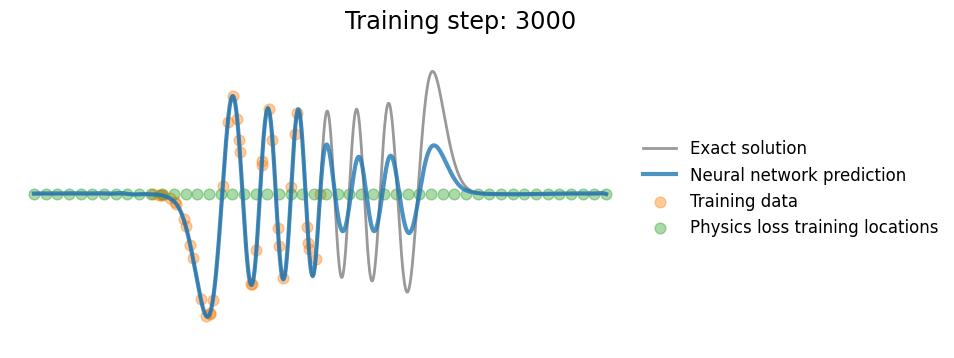

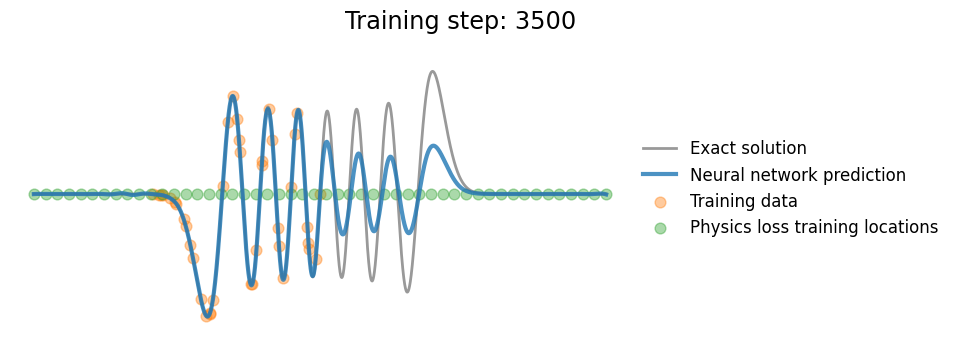

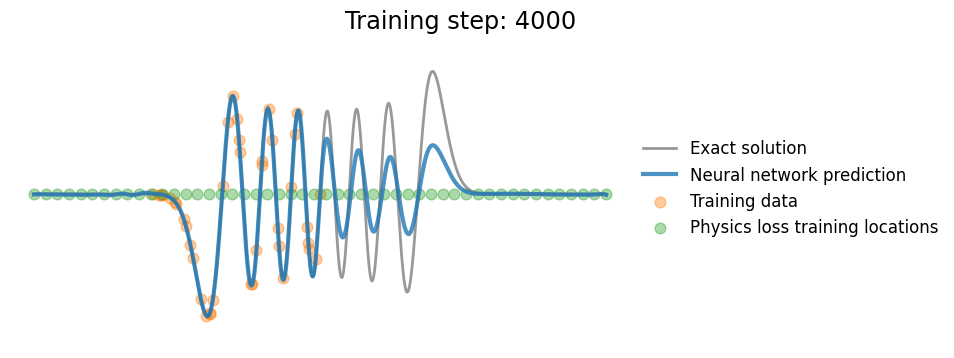

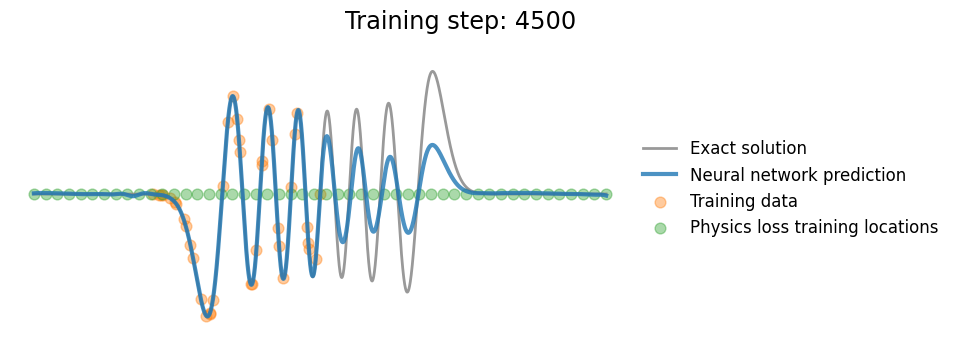

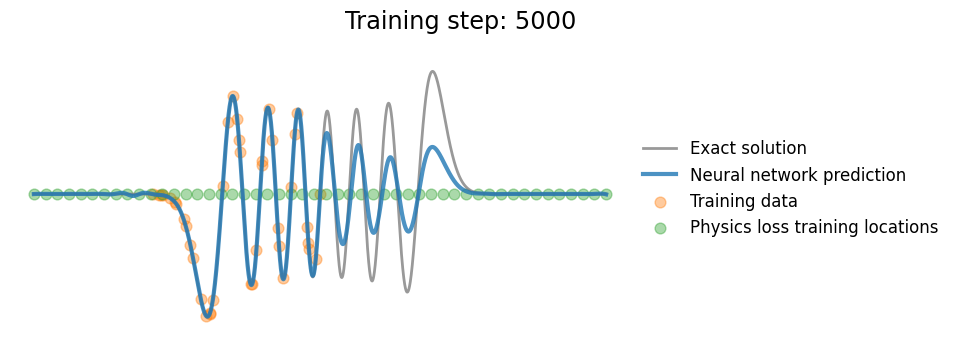

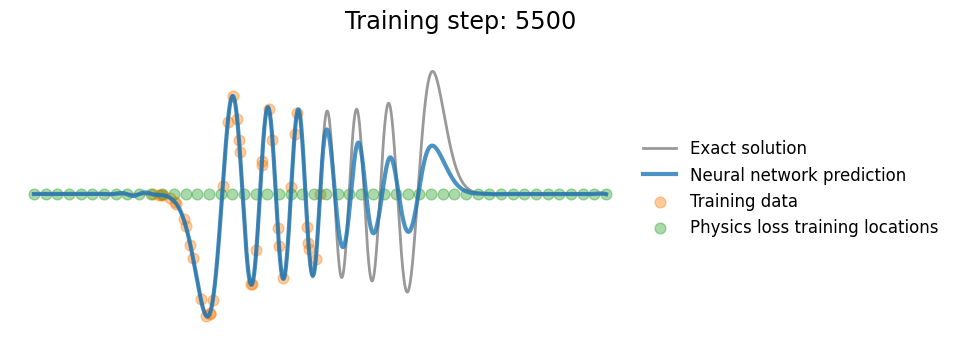

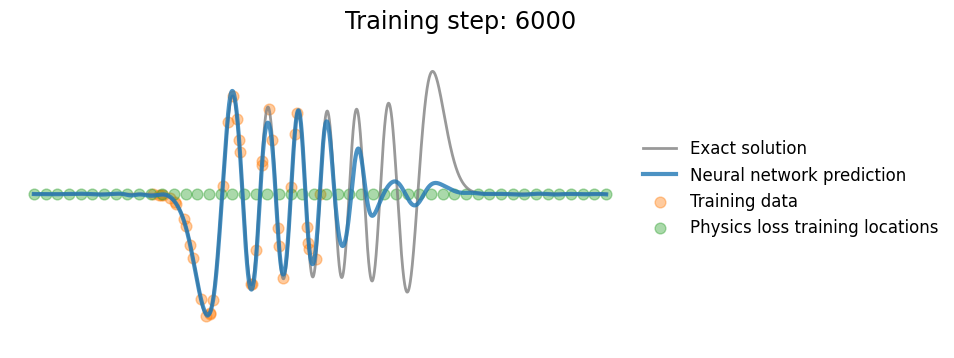

In [ ]:
x_physics = torch.linspace(-12,12,50).view(-1,1).requires_grad_(True) # sample locations over the problem domain

torch.manual_seed(123)
model = CustomNN(1,1,32,3)
#device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

optimizer = torch.optim.Adam(model.parameters(),lr=5e-3)

data_loss_history = []
physics_loss_history = []
total_loss_history = []

#plt.close()
for i in range(6000):
    optimizer.zero_grad()

    # compute the "data loss"
    yh = model(x_perturbed)
    loss1 = mse_loss(yh,y_data)
    data_loss_history.append(loss1.item())

    # compute the "physics loss"
    loss2 = physics_loss(model, x_physics, n)
    scaled = 5e-3
    loss2 = loss2 * scaled
    physics_loss_history.append(loss2.item())

    # backpropagate joint loss
    loss = loss1 + loss2# add two loss terms together
    total_loss_history.append(loss.item())
    loss.backward()
    optimizer.step()

    # plot the result as training progresses
    if (i+1) % 5 == 0:
        yh = model(x).detach()
        xp = x_physics.detach()
        xlim_low = -13
        xlim_high = 13
        ylim_low = -0.65
        ylim_high = 0.65
        plot_result(x,y,x_perturbed,y_data,yh,xlim_low,xlim_high,ylim_low,ylim_high,xp)

        if (i+1) % 500 == 0: plt.show()
        else: plt.close("all")

# 2D Quantum Harmonic Oscillator

The potential for the 2D quantum harmonic oscillator is given by $$V(x, y) = \frac{1}{2}m\omega^2 (x^2 + y^2)$$.

The time-dependent Schrödinger equation for a particle of mass $m$ in this potential is:

$$i\hbar \frac{\partial}{\partial t} \Psi(x, y, t) = \left[ -\frac{\hbar^2}{2m} \left( \frac{\partial^2}{\partial x^2} + \frac{\partial^2}{\partial y^2} \right) + V(x, y) \right] \Psi(x, y, t)$$


We assume that the solution can be separated into spatial and temporal parts:$\Psi(x, y, t) = \psi(x, y) \phi(t)$. For the spatial part, the equation becomes the time-independent Schrödinger equation:

$$-\frac{\hbar^2}{2m} \left( \frac{\partial^2}{\partial x^2} + \frac{\partial^2}{\partial y^2} \right) \psi(x, y) + \frac{1}{2} m \omega^2 (x^2 + y^2) \psi(x, y) = E \psi(x, y)$$

The spatial solution $\psi(x, y)$ can be written as a product of the wavefunctions in the $x$- and $y$-directions:

$$\psi_{n_x, n_y}(x, y) = \psi_{n_x}(x) \psi_{n_y}(y)$$

where $n_x$ and $n_y$ are the quantum numbers corresponding to the $x$- and $y$-coordinates, and each component satisfies the 1D harmonic oscillator equation. The solution for each spatial part is given by:

$$\psi_{n}(x) = \left( \frac{m \omega}{\pi \hbar} \right)^{1/4} \frac{1}{\sqrt{2^n n!}} H_n \left( \sqrt{\frac{m \omega}{\hbar}} x \right) e^{-\frac{m \omega x^2}{2 \hbar}}$$

where $H_n$ are the Hermite polynomials.


The energy levels of the 2D harmonic oscillator are given by:

$E_{n_x, n_y} = \hbar \omega \left( n_x + n_y + 1 \right)$

where $n_x$ and $n_y$ are non-negative integers.


We assume the wavefunction satisfies the appropriate boundary conditions for a quantum harmonic oscillator, which is typically that $\Psi(x, y, t) \to 0$ as $x, y \to \infty$. The independent variables are $x, y, t$, and the dependent variable is $\Psi(x, y, t)$. We assume standard quantum constants $ \hbar = 1$, $ m = 1$, and $ \omega = 1 $.


### Plotting the 2D hermite polynomials

You can verify result [from here](https://drpress.org/ojs/index.php/HSET/article/view/11282)

In [ ]:
def quantum_2d_harmonic_oscillator(n, s, x, y):
    """
    Quantum harmonic oscillator state function for n-th energy level in 2D.

    Parameters:
    - n: Quantum number for x-direction
    - s: Quantum number for y-direction
    - x: Position in x-direction (torch.Tensor)
    - y: Position in y-direction (torch.Tensor)

    Returns:
    - total_wavefunction: The wave function evaluated at x and y positions
    """
    # Given values
    m = 1.0  # mass
    omega = 1.0  # angular frequency
    hbar = 1.0  # reduced Planck's constant

    # Prefactor for both x and y
    prefactor_x = ((m*omega)/(np.pi*hbar))**0.25
    prefactor_y = ((m*omega)/(np.pi*hbar))**0.25

    # Compute the wave function for the x-direction
    normalization_x = 1 / np.sqrt(2**n * factorial(n))  # normalization factor
    x_np = x.cpu().numpy()  # convert torch tensor to numpy array for scipy
    H_n = hermite(n)(np.sqrt(m*omega/hbar) * x_np)  # Hermite polynomial
    psi_x_np = prefactor_x * normalization_x * H_n * np.exp(-m*omega*x_np**2 / (2*hbar))
    psi_x = torch.from_numpy(psi_x_np).type_as(x)  # convert back to torch tensor

    # Compute the wave function for the y-direction
    normalization_y = 1 / np.sqrt(2**s * factorial(s))  # normalization factor
    y_np = y.cpu().numpy()  # convert torch tensor to numpy array for scipy
    H_s = hermite(s)(np.sqrt(m*omega/hbar) * y_np)  # Hermite polynomial
    psi_y_np = prefactor_y * normalization_y * H_s * np.exp(-m*omega*y_np**2 / (2*hbar))
    psi_y = torch.from_numpy(psi_y_np).type_as(y)  # convert back to torch tensor

    # Total wave function is the product of psi_x and psi_y
    total_wavefunction = psi_x * psi_y

    return total_wavefunction


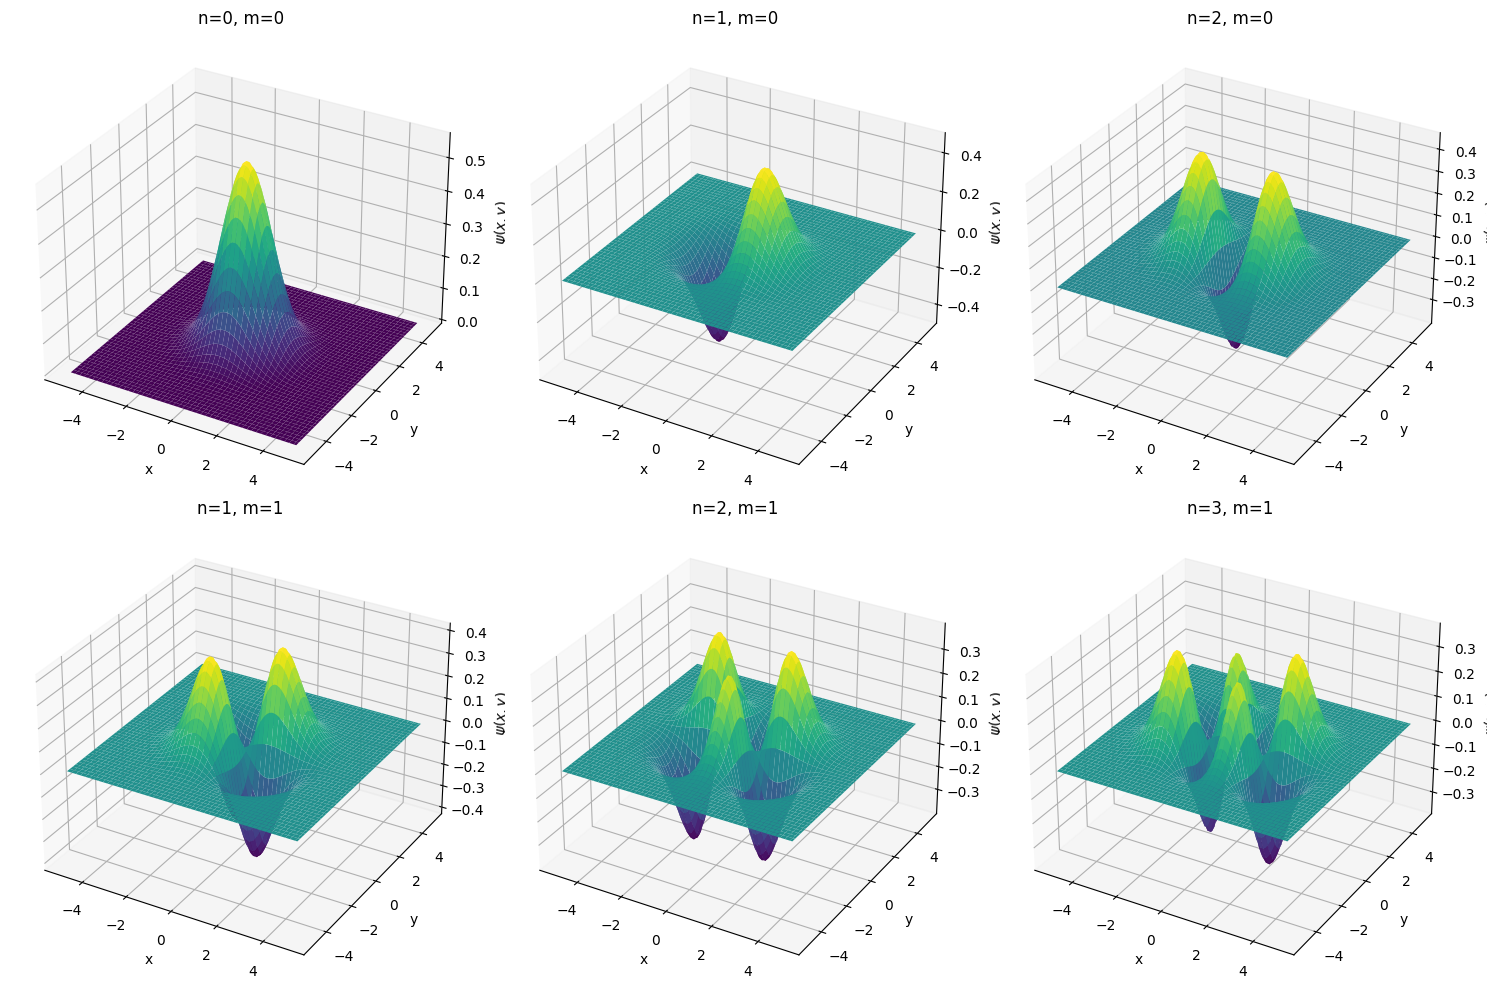

In [ ]:
# Define grid for plotting
x_vals = np.linspace(-5, 5, 100)
y_vals = np.linspace(-5, 5, 100)
x_grid, y_grid = np.meshgrid(x_vals, y_vals)

# Convert to torch tensors
x_torch = torch.from_numpy(x_grid)
y_torch = torch.from_numpy(y_grid)

# Define quantum numbers (n, m) for the plots
quantum_numbers = [(0, 0), (1, 0), (2, 0), (1, 1), (2, 1), (3, 1)]

# Set up the plot
fig, axes = plt.subplots(2, 3, subplot_kw={"projection": "3d"}, figsize=(15, 10))

for i, (n, s) in enumerate(quantum_numbers):
    wavefunction = quantum_2d_harmonic_oscillator(n, s, x_torch, y_torch).numpy()

    # Select the subplot
    ax = axes[i // 3, i % 3]
    ax.plot_surface(x_grid, y_grid, wavefunction, cmap='viridis', edgecolor='none')

    # Set labels and titles
    ax.set_title(f'n={n}, m={s}')
    ax.set_xlabel('x')
    ax.set_ylabel('y')
    ax.set_zlabel(r'$\psi(x, y)$')

# Adjust layout
plt.tight_layout()
plt.show()

### General NN Implementation for Quantum Wavefunction

The NN will remain the same as GeneralNN. But this time we assume that input come as pair (x, y) where x denotes the real part and y denotes the imaginary part. Subsequently, the output would also be (x', y') where x' denotes the real part and y' denotes the imaginary part. The map would be from $$f: \mathbb{R}^2 →  \mathbb{R}^2$$.

Until now, we have been assuming that wavefunctions are real-valued. However, we now deal with general wavefunctions which assume the form:

  $$\psi = \psi_{real} + i \psi_{complex} ∈ \mathbb{C} $$

As a result, we would now be solving two differential equations:

$$ H\psi_{real} = E \psi_{real} $$
$$ H\psi_{complex} = E \psi_{complex} $$

After applying the NN below, we will receive x which is a 2-dimensional output.
- psi_real = x[:, 0]  # Real part of the wavefunction
- psi_imag = x[:, 1]  # Imaginary part of the wavefunction

In [ ]:

class SchrodingerPINN(nn.Module):
    def __init__(self, N_INPUT, N_OUTPUT, N_HIDDEN, N_LAYERS):
        super(SchrodingerPINN, self).__init__()
        self.activation = torch.sin
        self.initial_layer = nn.Linear(N_INPUT, N_HIDDEN)
        self.hidden_layers = nn.ModuleList([nn.Linear(N_HIDDEN, N_HIDDEN) for _ in range(N_LAYERS - 1)])
        self.output_layer = nn.Linear(N_HIDDEN, N_OUTPUT)  # Output for both real and imaginary parts

    def forward(self, x, y):
        inputs = torch.cat((x, y), dim=1)
        x = self.activation(self.initial_layer(inputs))
        for hidden_layer in self.hidden_layers:
            x = self.activation(hidden_layer(x))
        x = self.output_layer(x)
        return x  # Output now includes both real and imaginary parts

### Physics Loss

In [ ]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

def schrodinger_loss(model, x, y):
    """
    # equation of interest is -0.5(psi_xx + psi_yy) + (V - E) psi  = 0
    # split into real and imaginary parts
    """
    # Forward pass to get the wavefunction (real and imaginary parts)
    psi_r, psi_i = model(x, y).chunk(2, dim=1)

    # Compute second-order gradients with respect to x and y
    def second_derivative(psi, input_var):
        grad_1st = torch.autograd.grad(psi, input_var, create_graph=True, grad_outputs=torch.ones_like(psi))[0]
        grad_2nd = torch.autograd.grad(grad_1st, input_var, create_graph=True, grad_outputs=torch.ones_like(grad_1st))[0]
        return grad_2nd

    # Compute second derivatives of the real and imaginary parts
    psi_r_xx = second_derivative(psi_r, x)
    psi_r_yy = second_derivative(psi_r, y)
    psi_i_xx = second_derivative(psi_i, x)
    psi_i_yy = second_derivative(psi_i, y)

    # Potential energy for the 2D quantum harmonic oscillator
    V = 0.5 * (x**2 + y**2)

    # Schrödinger equation loss for both real and imaginary parts
    loss_real = (-0.5 * (psi_r_xx + psi_r_yy) + V * psi_r) ** 2
    loss_imag = (-0.5 * (psi_i_xx + psi_i_yy) + V * psi_i) ** 2

    # Combine both losses
    loss = torch.mean(loss_real + loss_imag)

    return loss


### Training

The Gaussian wavefunction is a reasonable approximation of the ground state of the quantum harmonic oscillator, especially near the origin. The exact ground state of the quantum harmonic oscillator in 2D is also Gaussian-like, but with specific normalization and Hermite polynomial terms depending on the quantum numbers. Thus, we assume:

$$ \psi = exp(-0.5(x^2 + y^2)) $$

as the trial solution.

In [ ]:

# Define the network, optimizer, etc.

net = SchrodingerPINN(2, 2, 50, 4)
net = net.to(device)
optimizer = torch.optim.Adam(net.parameters())
mse_cost_function = torch.nn.MSELoss()

# Boundary conditions at the edges of the 2D domain
x_bc = np.linspace(-5, 5, 500)[:, None]
y_bc = np.linspace(-5, 5, 500)[:, None]

psi_bc = np.exp(-0.5 * (x_bc**2 + y_bc**2))  # Gaussian wave function for the 2D harmonic oscillator

boundary_loss_history = []
physics_loss_history = []
total_loss_history = []

# Training loop
for epoch in range(25000):
    optimizer.zero_grad()  # Reset gradients

    # Prepare boundary condition points
    pt_x_bc = torch.from_numpy(x_bc).float().to(device)
    pt_y_bc = torch.from_numpy(y_bc).float().to(device)

    real_part_bc = psi_bc  # Known real part of the wavefunction at the boundary
    imaginary_part_bc = np.zeros_like(psi_bc)  # Imaginary part is zero at the boundary

    boundary_wavefunction_bc = np.hstack([real_part_bc, imaginary_part_bc]) # Stack real and imaginary parts horizontally

    pt_psi_bc = torch.from_numpy(np.hstack([psi_bc, np.zeros_like(psi_bc)])).float().to(device)

    net_bc_out = net(pt_x_bc, pt_y_bc)
    boundary_loss = mse_cost_function(net_bc_out, pt_psi_bc)

    # Prepare random collocation points for PDE loss
    x_collocation = np.random.uniform(low=-5.0, high=5.0, size=(2000, 1))
    y_collocation = np.random.uniform(low=-5.0, high=5.0, size=(2000, 1))

    pt_x_collocation = torch.from_numpy(x_collocation).float().to(device)
    pt_x_collocation.requires_grad_(True)  # Enable gradient computation for this tensor

    pt_y_collocation = torch.from_numpy(y_collocation).float().to(device)
    pt_y_collocation.requires_grad_(True)  # Enable gradient computation for this tensor

    # Compute the physics-informed loss
    physics_loss = schrodinger_loss(net, pt_x_collocation, pt_y_collocation)

    # Total loss is the sum of boundary loss and physics-informed loss
    total_loss = boundary_loss + physics_loss
    boundary_loss_history.append(boundary_loss.item())
    physics_loss_history.append(physics_loss.item())
    total_loss_history.append(total_loss.item())

    total_loss.backward()
    optimizer.step()

    if epoch % 1000 == 0:
        print(f'Epoch {epoch}, Total Loss: {total_loss.item()}')

Epoch 0, Total Loss: 2.8317883014678955
Epoch 1000, Total Loss: 0.022144364193081856
Epoch 2000, Total Loss: 0.018910709768533707
Epoch 3000, Total Loss: 0.019582485780119896
Epoch 4000, Total Loss: 0.02049695886671543
Epoch 5000, Total Loss: 0.0211951844394207
Epoch 6000, Total Loss: 0.01942385733127594
Epoch 7000, Total Loss: 0.022057417780160904
Epoch 8000, Total Loss: 0.01986626721918583
Epoch 9000, Total Loss: 0.020898137241601944
Epoch 10000, Total Loss: 0.022379111498594284
Epoch 11000, Total Loss: 0.018742669373750687
Epoch 12000, Total Loss: 0.021875008940696716
Epoch 13000, Total Loss: 0.020099297165870667
Epoch 14000, Total Loss: 0.02021314762532711
Epoch 15000, Total Loss: 0.019485775381326675
Epoch 16000, Total Loss: 0.019246704876422882
Epoch 17000, Total Loss: 0.017393575981259346
Epoch 18000, Total Loss: 0.01978776417672634
Epoch 19000, Total Loss: 0.021895723417401314
Epoch 20000, Total Loss: 0.020281342789530754
Epoch 21000, Total Loss: 0.020731249824166298
Epoch 2200

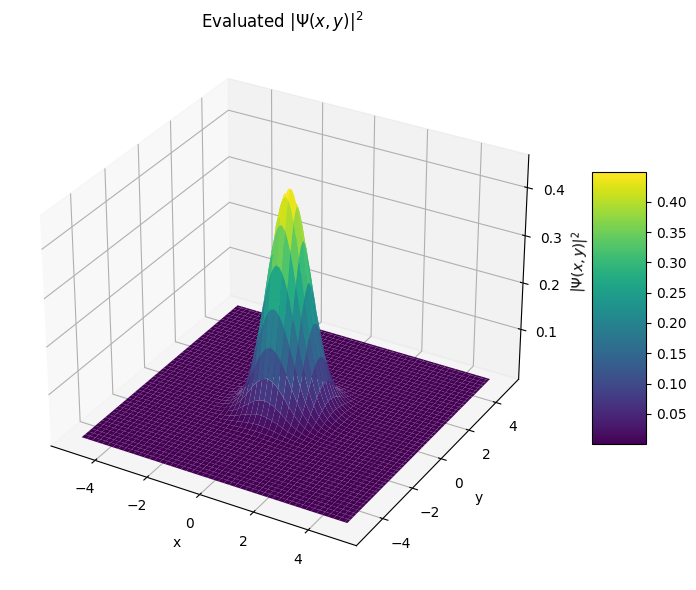

In [ ]:
# Define grid for plotting
x_vals = np.linspace(-5, 5, 100)
y_vals = np.linspace(-5, 5, 100)
x_grid, y_grid = np.meshgrid(x_vals, y_vals)

# Convert grid points to torch tensors for model evaluation
x_torch = torch.from_numpy(x_grid).float().to(device)
y_torch = torch.from_numpy(y_grid).float().to(device)

# Flatten the grid for evaluation
x_torch_flat = x_torch.flatten().view(-1, 1)
y_torch_flat = y_torch.flatten().view(-1, 1)

def evaluate_wavefunction(model, x_torch_flat, y_torch_flat):
    with torch.no_grad():
        psi = model(x_torch_flat, y_torch_flat)
        psi_real, psi_imag = psi[:, 0], psi[:, 1]  # Real and imaginary parts
        psi_magnitude = psi_real**2 + psi_imag**2  # Magnitude squared of the wavefunction
        return psi_magnitude.cpu().numpy()

# Evaluate the wavefunction on the flattened grid
psi_magnitude = evaluate_wavefunction(net, x_torch_flat, y_torch_flat)

# Reshape the output back to the original grid shape
psi_magnitude = psi_magnitude.reshape(x_grid.shape)



# Set up the 3D plot
fig = plt.figure(figsize=(8, 6))
ax = fig.add_subplot(111, projection='3d')

# Plot the surface
surf = ax.plot_surface(x_grid, y_grid, psi_magnitude, cmap='viridis', edgecolor='none')

# Set labels and titles
ax.set_title(r'Evaluated $|\Psi(x, y)|^2$')
ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_zlabel(r'$|\Psi(x, y)|^2$')

# Add a color bar for reference
fig.colorbar(surf, shrink=0.5, aspect=5)

# Show the plot
plt.tight_layout()
plt.show()